## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn import metrics as metrics

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import string

/Users/danielberry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
files = [f for f in os.listdir('../data/press_releases/') if 'csv' in f]

In [3]:
df = pd.DataFrame()

for file in files:
    new = pd.read_csv(f'../data/press_releases/{file}')
    df = pd.concat([df,new],ignore_index=True)

df.head()

,full_link,title,body,html,date,full_text,year,label
0,https://www.apple.com/newsroom/2021/03/apple-e...,Apple earns historic Academy Award nominations...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,earns historic Academy Award nominations for ...,2021,after
1,https://www.apple.com/newsroom/2021/03/apple-w...,Apple Women’s Health Study releases preliminar...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,Women’s Health Study releases preliminary dat...,2021,after
2,https://www.apple.com/newsroom/2021/03/apple-t...,Apple TV+ announces programming partnership wi...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,TV+ announces programming partnership with No...,2021,after
3,https://www.apple.com/newsroom/2021/03/apple-h...,Apple Hearing Study shares new insights on hea...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,Hearing Study shares new insights on hearing ...,2021,after
4,https://www.apple.com/newsroom/2021/03/new-zea...,New Zealand students prototype their own Samoa...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,New Zealand students prototype their own Samoa...,2021,after


In [4]:
df.label.value_counts(normalize=True)

# baseline is 0.539092

after     0.539092
before    0.460908
Name: label, dtype: float64

## Vectorizing

In [5]:
# https://python.plainenglish.io/text-classification-using-python-spacy-7a414abcc83a

# Load English tokenizer, tagger, parser, NER and word vectors
# Create list of punctuation marks
punctuations = string.punctuation

# Create list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS


# Creating our tokenizer function
def spacy_tokenizer(text):
    # Creating our token object, which is used to create
    # documents with linguistic annotations.
    mytokens = nlp(text)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [
        word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_
        for word in mytokens
    ]

    # Removing stop words
    mytokens = [
        word for word in mytokens
        if word not in stop_words and word not in punctuations
    ]

    # return preprocessed list of tokens
    return mytokens

# Custom transformer using spaCy

class predictors(TransformerMixin): 
    
    def transform(self, X, **transform_params):
        # Basic function to clean the text
        def clean_text(text):
            # Removing spaces and converting text into lowercase
            return text.strip().lower()
        
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [6]:
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer,
                        strip_accents='unicode',
                        max_features=4000,
                        max_df=.8,
                        min_df=.2,
                        ngram_range=(1, 2))

In [7]:
X = df['full_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=47,
                                                    stratify=y)

## Logistic Regression

In [8]:
# Logistic Regression Classifier - penalty: 'l2'

logr = LogisticRegression(penalty='l2')

pipe_l2 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf),
                 ('logr', logr)])

# model generation
pipe_l2.fit(X_train,y_train)
print('Train:', pipe_l2.score(X_train,y_train))
print('Test:', pipe_l2.score(X_test,y_test))

# baseline is 0.539092

# Train: 0.7594617325483599
# Test: 0.654911838790932

Train: 0.7594617325483599
Test: 0.654911838790932


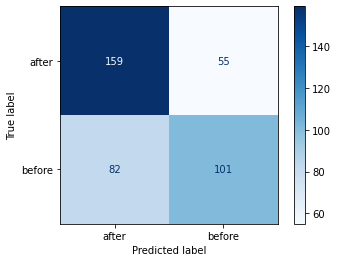

In [9]:
metrics.plot_confusion_matrix(pipe_l2, X_test, y_test, cmap='Blues', 
                              values_format='d');

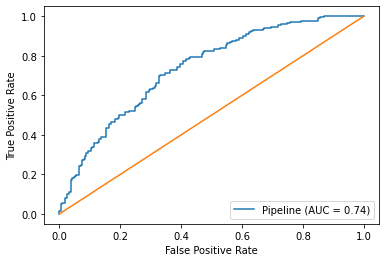

In [10]:
# ROC curve
metrics.plot_roc_curve(pipe_l2, X_test, y_test)
# add worst case scenario line
plt.plot([0, 1], [0, 1]);

In [11]:
metrics.roc_auc_score(y_test, pipe_l2.predict_proba(X_test)[:,1])

0.7365813799090957

In [28]:
# Logistic Regression Classifier - penalty: 'none'

logr = LogisticRegression(penalty='none')

pipe_none = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf),
                 ('logr', logr)])

# model generation
pipe_none.fit(X_train,y_train)
print('Train:', pipe_none.score(X_train,y_train))
print('Test:', pipe_none.score(X_test,y_test))

# baseline is 0.539092

# Train: 1.0
# Test: 0.8535031847133758

AttributeError: 'str' object has no attribute 'decode'

In [ ]:
metrics.plot_confusion_matrix(pipe_none, X_test, y_test, cmap='Blues', 
                              values_format='d');

In [ ]:
# ROC curve
metrics.plot_roc_curve(pipe_none, X_test, y_test)
# add worst case scenario line
plt.plot([0, 1], [0, 1]);

In [ ]:
metrics.roc_auc_score(y_test, pipe_none.predict_proba(X_test)[:,1])

## KNN

In [13]:
# KNN Classifier - Neighbors = 8

knn = KNeighborsClassifier(n_neighbors=8,n_jobs=-1)

pipen8 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf),
                 ('knn', knn)])

# model generation
pipen8.fit(X_train,y_train)
print('Train:', pipen8.score(X_train,y_train))
print('Test:', pipen8.score(X_test,y_test))

# baseline is 0.539092

# Train: 0.7493692178301093
# Test: 0.672544080604534

Train: 0.7493692178301093
Test: 0.672544080604534


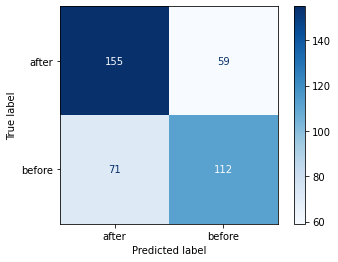

In [14]:
metrics.plot_confusion_matrix(pipen8, X_test, y_test, cmap='Blues', 
                              values_format='d');

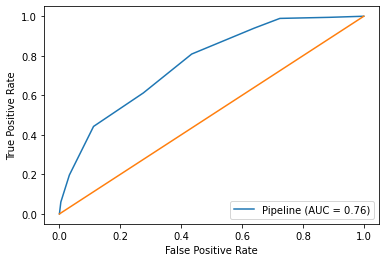

In [15]:
# ROC curve
metrics.plot_roc_curve(pipen8, X_test, y_test)
# add worst case scenario line
plt.plot([0, 1], [0, 1]);

In [27]:
metrics.roc_auc_score(y_test, pipen8.predict_proba(X_test)[:,1])

0.7631888054746949

In [19]:
# KNN Classifier - Neighbors = 5

knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)

pipen5 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf),
                 ('knn', knn)])

# model generation
pipen5.fit(X_train,y_train)
print('Train:', pipen5.score(X_train,y_train))
print('Test:', pipen5.score(X_test,y_test))

# baseline is 0.539092

# Train: 0.7821698906644239
# Test: 0.7128463476070529

Train: 0.7821698906644239
Test: 0.7128463476070529


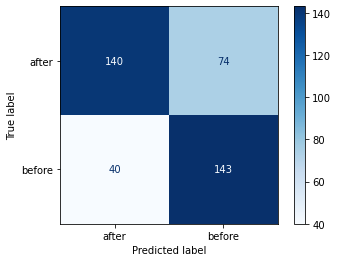

In [20]:
metrics.plot_confusion_matrix(pipen5, X_test, y_test, cmap='Blues', 
                              values_format='d');

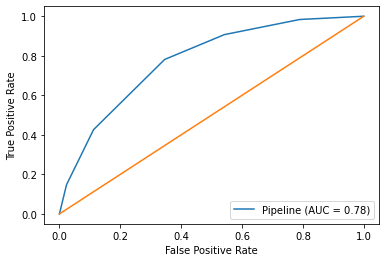

In [21]:
# ROC curve
metrics.plot_roc_curve(pipen5, X_test, y_test)
# add worst case scenario line
plt.plot([0, 1], [0, 1]);

In [22]:
metrics.roc_auc_score(y_test, pipen5.predict_proba(X_test)[:,1])

0.7766584954803125

In [23]:
# KNN Classifier - Neighbors = 3

knn = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)

pipen3 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf),
                 ('knn', knn)])

# model generation
pipen3.fit(X_train,y_train)
print('Train:', pipen3.score(X_train,y_train))
print('Test:', pipen3.score(X_test,y_test))

# baseline is 0.539092

# Train: 0.8317914213624895
# Test: 0.707808564231738

Train: 0.8317914213624895
Test: 0.707808564231738


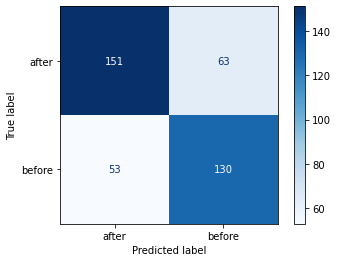

In [24]:
metrics.plot_confusion_matrix(pipen3, X_test, y_test, cmap='Blues', 
                              values_format='d');

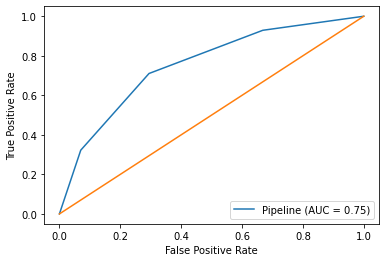

In [25]:
# ROC curve
metrics.plot_roc_curve(pipen3, X_test, y_test)
# add worst case scenario line
plt.plot([0, 1], [0, 1]);

In [26]:
metrics.roc_auc_score(y_test, pipen3.predict_proba(X_test)[:,1])

0.7535365915938921